
--- EXPERIMENT 1: Linear SEM (X1 → Y, X2 ⊥ Y) ---

 accepted set of variables 1
 *** 50% complete: tested 2 of 4 sets of variables 
 accepted set of variables 1,2ICP accepted sets: [<rpy2.robjects.vectors.IntVector object at 0x0000020DC7FCD950> [13]
R classes: ('integer',)
[1], <rpy2.robjects.vectors.IntVector object at 0x0000020DC5FAE310> [13]
R classes: ('integer',)
[1, 2]]

--- EXPERIMENT 2: Nonlinear SEM (Y = 1.5*X1 + 0.5*X1^2) ---

 *** 50% complete: tested 2 of 4 sets of variables ICP accepted sets: []


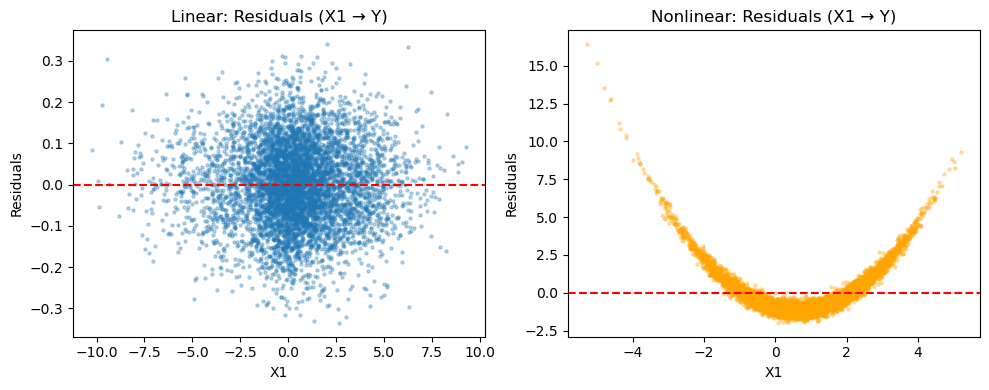

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import r
import rpy2.robjects as ro

# Import R's ICP package
icp_r = importr('InvariantCausalPrediction')
np.random.seed(42)


def generate_simple_linear_sem(n_samples, env_type='obs'):
    """
    Simplest structure:
    X1 → Y (true causal parent)
    X2 ⊥ Y (independent, no relation)
    """
    X1 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)  # completely independent
    
    if env_type == 'int1':
        X1 = X1 + 2
    elif env_type == 'int2':
        X1 = 3 * X1   # scale instead of shift
    
    Y = 1.5 * X1 + np.random.randn(n_samples) * 0.1
    
    return np.column_stack([X1, X2]), Y


def generate_simple_nonlinear_sem(n_samples, env_type='obs'):
    """
    Nonlinear: Y = 1.5*X1 + 0.5*X1^2 + noise
    X2 still independent
    """
    X1 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)
    
    if env_type == 'int1':
        X1 = X1 + 2.0
    elif env_type == 'int2':
        X1 = X1 * 1.5
    
    Y = 1.5 * X1 + 0.5 * X1**2 + np.random.randn(n_samples) * 0.3
    
    return np.column_stack([X1, X2]), Y


def run_icp(X, Y, env_labels):
    """Call R's ICP function"""
    X_r = ro.r.matrix(ro.FloatVector(X.T.flatten()), nrow=X.shape[0], ncol=X.shape[1])
    Y_r = ro.FloatVector(Y)
    env_r = ro.IntVector(env_labels)
    result = icp_r.ICP(X_r, Y_r, env_r, alpha=0.1)
    return list(result.rx2('acceptedSets'))


# ============================================================================
# Experiment 1: Linear SEM
# ============================================================================

print("\n--- EXPERIMENT 1: Linear SEM (X1 → Y, X2 ⊥ Y) ---")

n = 2000  # increased sample size for better power
X1, Y1 = generate_simple_linear_sem(n, 'obs')
X2, Y2 = generate_simple_linear_sem(n, 'int1')
X3, Y3 = generate_simple_linear_sem(n, 'int2')

X_linear = np.vstack([X1, X2, X3])
Y_linear = np.hstack([Y1, Y2, Y3])
env_linear = np.array([1]*n + [2]*n + [3]*n)

result_linear = run_icp(X_linear, Y_linear, env_linear)
print(f"ICP accepted sets: {result_linear}")


# ============================================================================
# Experiment 2: Nonlinear SEM
# ============================================================================

print("\n--- EXPERIMENT 2: Nonlinear SEM (Y = 1.5*X1 + 0.5*X1^2) ---")

X1_nl, Y1_nl = generate_simple_nonlinear_sem(n, 'obs')
X2_nl, Y2_nl = generate_simple_nonlinear_sem(n, 'int1')
X3_nl, Y3_nl = generate_simple_nonlinear_sem(n, 'int2')

X_nonlin = np.vstack([X1_nl, X2_nl, X3_nl])
Y_nonlin = np.hstack([Y1_nl, Y2_nl, Y3_nl])
env_nonlin = np.array([1]*n + [2]*n + [3]*n)

result_nonlin = run_icp(X_nonlin, Y_nonlin, env_nonlin)
print(f"ICP accepted sets: {result_nonlin}")


# ============================================================================
# Visualization: Compare residual patterns
# ============================================================================

from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Linear case residuals
model_lin = LinearRegression()
model_lin.fit(X_linear[:, 0].reshape(-1, 1), Y_linear)
res_lin = Y_linear - model_lin.predict(X_linear[:, 0].reshape(-1, 1))

axes[0].scatter(X_linear[:, 0], res_lin, alpha=0.3, s=5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Linear: Residuals (X1 → Y)')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('Residuals')

# Nonlinear case residuals
model_nl = LinearRegression()
model_nl.fit(X_nonlin[:, 0].reshape(-1, 1), Y_nonlin)
res_nl = Y_nonlin - model_nl.predict(X_nonlin[:, 0].reshape(-1, 1))

axes[1].scatter(X_nonlin[:, 0], res_nl, alpha=0.3, s=5, color='orange')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Nonlinear: Residuals (X1 → Y)')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.savefig('icp_experiment_result.png', dpi=300, bbox_inches='tight')
plt.show()